In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [2]:
account = pd.read_csv('data/account.csv', delimiter=";")
card_test = pd.read_csv('data/card_test.csv', delimiter=";")
card_train = pd.read_csv('data/card_train.csv', delimiter=";")
client = pd.read_csv('data/client.csv', delimiter=";")
disp = pd.read_csv('data/disp.csv', delimiter=";")
district = pd.read_csv('data/district.csv', delimiter=";")
loan_test = pd.read_csv('data/loan_test.csv', delimiter=";")
loan_train = pd.read_csv('data/loan_train.csv', delimiter=";")
trans_test = pd.read_csv('data/trans_test.csv', delimiter=";")
trans_train = pd.read_csv('data/trans_train.csv', delimiter=";")


/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Account
- account_id
- district_id
- date
- frequency

# Client
- client_id
- birth_number
- district_id

# Disposition
- disp_id
- client_id
- account_id
- type

# Loan
- loan_id
- account_id
- date
- amount
- duration
- payments
- status

# Transition
- trans_id
- account_id
- date
- type
- operation
- amount_balance
- k_symbol
- bank
- account

In [3]:
def renameColumns():
    account.rename({'date': 'account_date', 'district_id': 'account_district_id'}, axis=1, inplace = True)
    client.rename({'district_id': 'client_district_id'}, axis=1, inplace = True)
    loan_train.rename({'date': 'loan_date'}, axis=1, inplace = True)
    loan_test.rename({'date': 'loan_date'}, axis=1, inplace = True)

In [4]:
def getGender(df):
    list = []
    for row in df.itertuples(index = True):
        month = getMonth(row.birth_number)
        birth_number = row.birth_number
        gender = 'M'
        
        if(month > 50):
            birth_number -= 5000
            gender = 'F'
            
        list.append([row.client_id, birth_number, gender, row.client_district_id])
    
    return pd.DataFrame(list, columns=['client_id', 'birth_number', 'gender', 'client_district_id'])

In [5]:
def getMonth(date):
    remove_day = date //100
    month = remove_day % 100
    return month

In [6]:
def getLoansInfo(loan_df):
    client_processed = getGender(client)
    merge1 = pd.merge(client_processed, disp, on ='client_id')
    merge2 = pd.merge(merge1, account, on = 'account_id')
    loan_info = pd.merge(loan_df, merge2, on = 'account_id')
    return loan_info

In [7]:
renameColumns()
loans = getLoansInfo(loan_train)
loans_test = getLoansInfo(loan_test)

In [8]:
from sklearn.preprocessing import LabelEncoder

df = loans.copy()
for f in df.columns:
    if df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

X= df.drop(columns='status')
y = df['status'].copy()

df_test = loans_test.copy()

for f in df_test.columns:
    if df_test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(df_test[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))

X_test = df_test.drop(columns='status')
y_test = df_test['status'].copy()


In [9]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#	test_size = 0.30, random_state = 0)

In [10]:
from sklearn.model_selection import RandomizedSearchCV, KFold

def find_best_params_kfold(model, X, y, param_grid, n_iter=10, n_splits=3):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    search = RandomizedSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, n_iter=n_iter, cv=kfold, verbose=0, random_state=0)
    result = search.fit(X, y)
    
    report(result.cv_results_)

In [11]:
def report(results, n_top=3):
    res = []
    res_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            res.append([np.multiply(results['mean_test_score'][candidate], -1), 
                        results['std_test_score'][candidate]])
            for key in results['params'][candidate].keys():
                res[res_i].append(results['params'][candidate][key])
            res_i+=1
    
    columns = ['Mean absolute error', 'std'] + list(results['params'][candidate].keys())
    display(pd.DataFrame(res, columns=columns))

In [12]:
def cross_validationScores(modelName, model, X, y, n_folds=10):
    metrics = {'MAE': 'neg_mean_absolute_error', 
               'RMSE': 'neg_root_mean_squared_error'}
    
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    scores = cross_validate(model, X, y, cv=kfold, scoring=metrics, n_jobs=-1)

    # multiply by -1 because sklearn scoring metrics are negative
    mean_mae_score = np.multiply(scores['test_MAE'], -1).mean()
    std_mae_score = np.multiply(scores['test_MAE'], -1).std()
    mean_rmse_score = np.multiply(scores['test_RMSE'], -1).mean()
    std_rmse_score = np.multiply(scores['test_RMSE'], -1).std()

    model_score = pd.DataFrame([[mean_mae_score, mean_rmse_score]], 
                             columns=['MAE', 'RMSE'], index=[modelName])
    global models_mean_scores
    models_mean_scores = models_mean_scores.append(model_score)

    print(str(n_folds) + " fold Cross validation scores for " + modelName)
    score_df = pd.DataFrame([[mean_mae_score, std_mae_score], 
                                  [mean_rmse_score, std_rmse_score]], 
                                 columns=['Mean score', 'std'], 
                                 index=['MAE', 'RMSE'])
    display(score_df)

In [ ]:
#from sklearn import tree

#X_train = df.drop(columns='status')
#y_train = loan['status'].copy()
#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X, y)

#X_test = loan_test.drop(columns='status')
#y_test = clf.predict(X_test)

In [ ]:
predict_loan = {'Id': X_test["loan_id"], 'Predicted': y_test}
df = pd.DataFrame(data=predict_loan)
df.to_csv('loan_predict.csv', index=False)

In [45]:
from sklearn.tree import DecisionTreeClassifier

max_depth = range(2, 30, 1)
min_samples_split = range(1, 10, 1)

param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split)

find_best_params_kfold(DecisionTreeClassifier(random_state=0), X, y, param_grid, 
                       n_iter=50, n_splits=10)

,Mean absolute error,std,min_samples_split,max_depth
0,0.334659,0.164505,9,2
1,0.334659,0.164505,6,2
2,0.335038,0.135864,5,4


In [61]:
classifier_cart = DecisionTreeClassifier(max_depth=2, min_samples_split=9, random_state=0)
classifier_cart = classifier_cart.fit(X, y)

y_test_cart = classifier_cart.predict(X_test)

#df_pred = pd.DataFrame(data={'Id': X_test["loan_id"], 'Predicted': y_test_cart})
#df_pred.to_csv('loan_pred_1.csv', index=False)

In [63]:
y_test_cart = classifier_cart.predict(X_test)
#df_pred = pd.DataFrame(data={'Id': X_test_owner["loan_id"], 'Predicted': y_test_cart})
#df_pred.to_csv('loan_pred_3.csv', index=False)
y_test_cart

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [47]:
from sklearn.ensemble import BaggingClassifier
n_estimators = range(50, 1000, 50)
param_grid = dict(n_estimators=n_estimators)

find_best_params_kfold(BaggingClassifier(base_estimator=regr_cart,
                                        n_jobs=-1, random_state=0), 
                       X, y, param_grid, n_iter=30, n_splits=3)

NameError: name 'regr_cart' is not defined

In [49]:
X_test_owner = X_test[X_test['type']==1]

In [18]:
loan_train

,loan_id,account_id,loan_date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1
...,...,...,...,...,...,...,...
323,6818,9030,961212,155616,48,3242,1
324,5625,3189,961215,222180,60,3703,-1
325,6805,8972,961221,45024,48,938,1
326,7233,10963,961225,115812,36,3217,1


In [57]:
df_owner = df[df['type']==1]
df_owner = df_owner[['loan_id', 'loan_date', 'account_date', 'amount', 'duration', 'payments', 'account_district_id', 'client_district_id', 'status']]
X= df_owner.drop(columns='status')
y = df_owner['status'].copy()
X_test = X_test[['loan_id', 'loan_date', 'account_date', 'amount', 'duration', 'payments', 'account_district_id', 'client_district_id']]

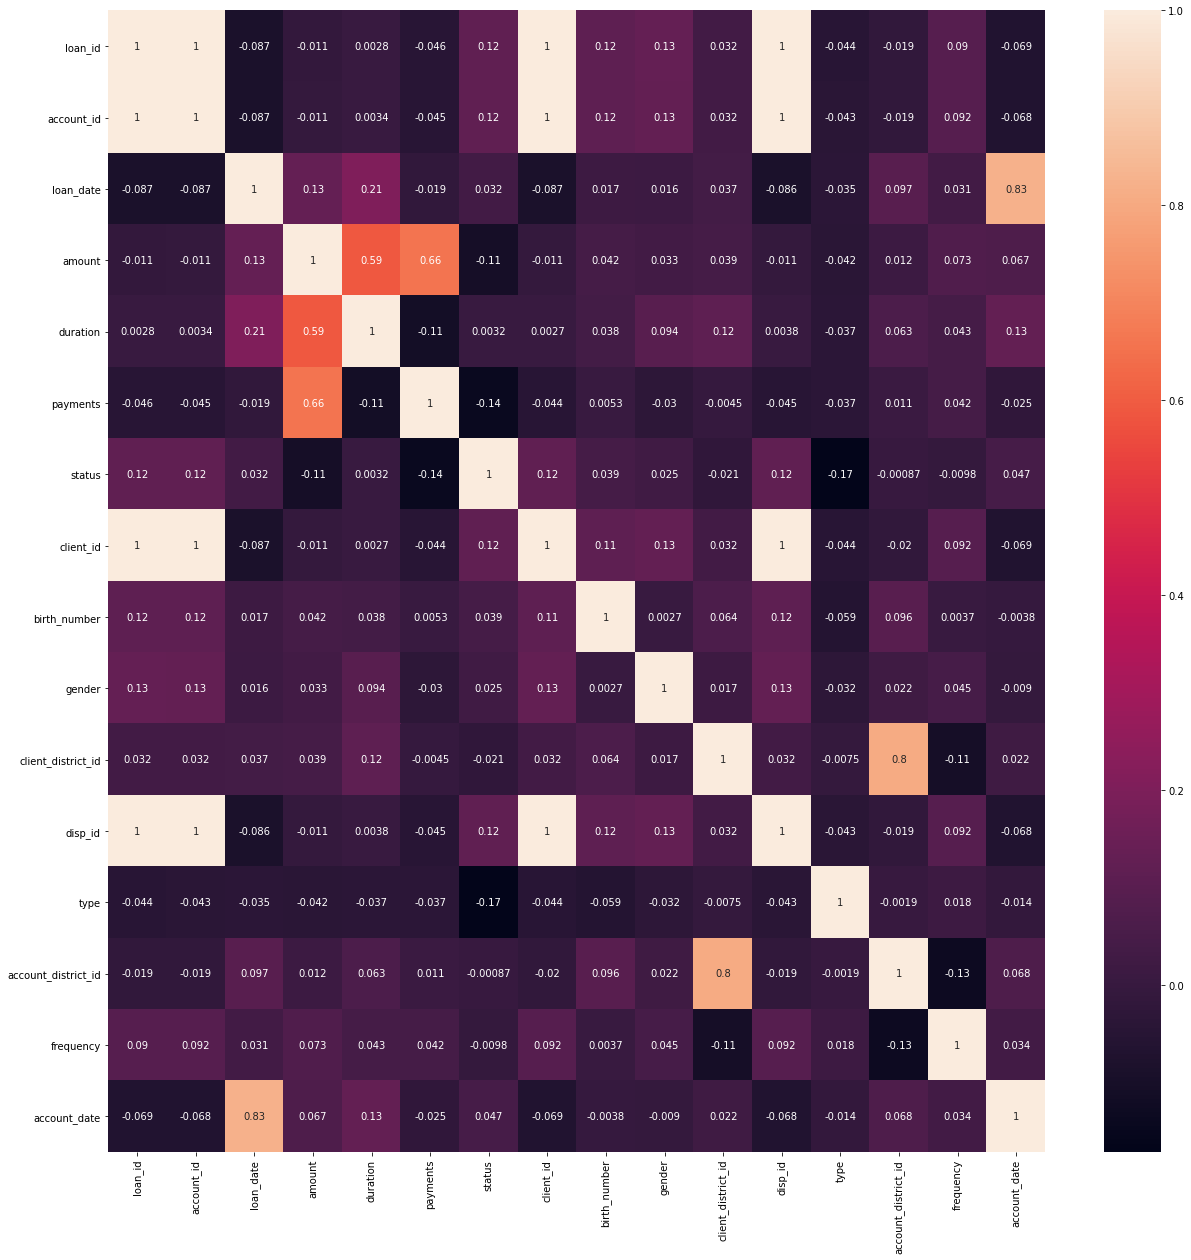

In [37]:
ax = plt.subplots(figsize=(21, 21))
ax = sns.heatmap(df.corr(), annot= True)

In [55]:
df_owner

,loan_id,loan_date,account_date,amount,duration,payments,account_district_id,client_district_id,status
0,5314,930705,930322,96396,12,8033,30,30,-1
1,5316,930711,930213,165960,36,4610,46,46,1
2,6863,930728,930208,127080,60,2118,45,45,1
3,5325,930803,930130,105804,36,2939,12,14,1
4,7240,930906,930214,274740,60,4579,1,63,1
...,...,...,...,...,...,...,...,...,...
397,6818,961212,950121,155616,48,3242,72,72,1
399,5625,961215,951129,222180,60,3703,29,29,-1
400,6805,961221,960521,45024,48,938,70,70,1
401,7233,961225,950520,115812,36,3217,16,16,1
